In [17]:
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test.drop(["Clearsky DHI","Clearsky DNI","Clearsky GHI"],axis=1,inplace=True)
test_y = pd.read_csv("sample_submission.csv")
correlated_Columns = ["Clearsky DHI","Clearsky DNI","Solar Zenith Angle","Temperature"]
test = pd.concat([test,test_y],axis=1)

In [3]:
Scaler = MinMaxScaler()



In [4]:
train_GHI = train["Clearsky GHI"].values
train.drop(["Clearsky GHI"],axis=1,inplace=True)
train.drop(correlated_Columns,axis=1,inplace=True)
test_GHI = test["Clearsky GHI"].values

test.drop(["Clearsky GHI"],axis=1,inplace=True)
test.drop(correlated_Columns,axis=1,inplace=True)
#train_GHI = Scaler.fit_transform(train_GHI.reshape(-1,1))
#test_GHI = Scaler.fit_transform(test_GHI.reshape(-1,1))



In [5]:
train

,Year,Month,Day,Hour,Minute,Cloud Type,Dew Point,Pressure,Relative Humidity,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
0,2009,1,1,0,0,0,0.0,1010,75.34,0.499,346.1,3.1,0
1,2009,1,1,0,30,0,1.0,1010,80.81,0.490,346.1,3.1,0
2,2009,1,1,1,0,4,0.0,1010,78.27,0.482,347.9,3.2,0
3,2009,1,1,1,30,4,0.0,1010,78.27,0.478,347.9,3.1,0
4,2009,1,1,2,0,4,0.0,1010,76.45,0.475,350.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018,12,31,21,30,4,19.4,1008,91.77,3.700,204.0,3.5,100
175292,2018,12,31,22,0,4,19.1,1008,93.88,3.800,209.0,3.2,100
175293,2018,12,31,22,30,7,19.1,1008,96.83,3.800,208.0,2.6,57
175294,2018,12,31,23,0,7,18.7,1009,96.84,3.700,206.0,2.1,0


In [6]:
train["Datetime"] = pd.to_datetime(train[['Year', 'Month', 'Day', 'Hour', 'Minute']])
test["Datetime"] = pd.to_datetime(test[['Year', 'Month', 'Day', 'Hour', 'Minute']])


In [7]:
train.set_index("Datetime",inplace=True)
test.set_index("Datetime",inplace=True)

In [8]:
train.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)
test.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)

In [9]:
train

,Cloud Type,Dew Point,Pressure,Relative Humidity,Precipitable Water,Wind Direction,Wind Speed,Fill Flag
Datetime,,,,,,,,
2009-01-01 00:00:00,0,0.0,1010,75.34,0.499,346.1,3.1,0
2009-01-01 00:30:00,0,1.0,1010,80.81,0.490,346.1,3.1,0
2009-01-01 01:00:00,4,0.0,1010,78.27,0.482,347.9,3.2,0
2009-01-01 01:30:00,4,0.0,1010,78.27,0.478,347.9,3.1,0
2009-01-01 02:00:00,4,0.0,1010,76.45,0.475,350.0,3.0,0
...,...,...,...,...,...,...,...,...
2018-12-31 21:30:00,4,19.4,1008,91.77,3.700,204.0,3.5,100
2018-12-31 22:00:00,4,19.1,1008,93.88,3.800,209.0,3.2,100
2018-12-31 22:30:00,7,19.1,1008,96.83,3.800,208.0,2.6,57


In [10]:
train = Scaler.fit_transform(train)
test = Scaler.fit_transform(test)



In [11]:
train_GHI

array([ 0,  0,  0, ..., 18,  0,  0], dtype=int64)

In [12]:
def createSequence(data,window_size):
    sequences = []
    for i in range(0,len(data) - window_size +1):
        sequence = data[i:i+window_size]
        sequences.append(sequence)
    return np.array(sequences)

    

        

sequences_48 = createSequence(train,window_size=48) # 1 day
sequences_96 = createSequence(train,window_size=96) # 2 day
sequences_144 = createSequence(train,window_size=144) # 3 day



In [13]:
train_GHI_48  = createSequence(train_GHI,window_size=48)
train_GHI_96  = createSequence(train_GHI,window_size=96)
train_GHI_144  = createSequence(train_GHI,window_size=144)


In [36]:
def createModel(input_size):
    model = Sequential()
    model.add(LSTM(32,input_shape=(input_size,8),return_sequences=True))
    model.add(LSTM(32))
    #model.add(Dense(64,activation="relu"))
    model.add(Dense(1,activation="relu"))
    model.compile(loss="mse",optimizer=Adam(learning_rate=0.001))
    return model


In [37]:
model_48 = createModel(48)
model_96 = createModel(96)
model_144 = createModel(144)

In [38]:
hist_48 = model_48.fit(sequences_48,train_GHI_48,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
2191/2191 [==============================] - 43s 18ms/step - loss: 153109.6875 - val_loss: 140170.7969
Epoch 2/10
2191/2191 [==============================] - 37s 17ms/step - loss: 130103.4609 - val_loss: 122126.9141
Epoch 3/10
2191/2191 [==============================] - 38s 17ms/step - loss: 116229.9844 - val_loss: 112022.2656
Epoch 4/10
2191/2191 [==============================] - 37s 17ms/step - loss: 109450.5859 - val_loss: 108098.0312
Epoch 5/10
2191/2191 [==============================] - 38s 17ms/step - loss: 107523.9844 - val_loss: 107522.5859
Epoch 6/10
2191/2191 [==============================] - 36s 16ms/step - loss: 107375.0391 - val_loss: 107517.4219
Epoch 7/10
2191/2191 [==============================] - 37s 17ms/step - loss: 107371.8672 - val_loss: 107517.0547
Epoch 8/10
2191/2191 [==============================] - 37s 17ms/step - loss: 107362.4219 - val_loss: 107623.7344
Epoch 9/10
2191/2191 [==============================] - 38s 17ms/step - loss: 106769.523

In [39]:
hist_96 = model_96.fit(sequences_96,train_GHI_96,epochs=10,batch_size=16,validation_split=0.2)


Epoch 1/10
8760/8760 [==============================] - 235s 27ms/step - loss: 126789.6094 - val_loss: 108008.8672
Epoch 2/10
8760/8760 [==============================] - 219s 25ms/step - loss: 107454.1484 - val_loss: 107662.4688
Epoch 3/10
8760/8760 [==============================] - 194s 22ms/step - loss: 106180.8672 - val_loss: 105164.1719
Epoch 4/10
8760/8760 [==============================] - 201s 23ms/step - loss: 104602.2969 - val_loss: 104709.1562
Epoch 5/10
8760/8760 [==============================] - 209s 24ms/step - loss: 104008.8438 - val_loss: 104368.4922
Epoch 6/10
8760/8760 [==============================] - 201s 23ms/step - loss: 103416.1875 - val_loss: 104221.0312
Epoch 7/10
8760/8760 [==============================] - 222s 25ms/step - loss: 103240.2969 - val_loss: 104725.4453
Epoch 8/10
8760/8760 [==============================] - 197s 22ms/step - loss: 103170.6016 - val_loss: 105211.3125
Epoch 9/10
8760/8760 [==============================] - 220s 25ms/step - loss: 1

In [41]:
hist_144 = model_144.fit(sequences_144,train_GHI_144,epochs=10,batch_size=64,validation_split=0.2)

Epoch 1/10
2190/2190 [==============================] - 72s 33ms/step - loss: 136364.2188 - val_loss: 126745.7891
Epoch 2/10
2190/2190 [==============================] - 69s 31ms/step - loss: 119515.1172 - val_loss: 114168.1250
Epoch 3/10
2190/2190 [==============================] - 65s 30ms/step - loss: 110707.8047 - val_loss: 108676.9219
Epoch 4/10
2190/2190 [==============================] - 73s 34ms/step - loss: 107747.6250 - val_loss: 107577.3984
Epoch 5/10
2190/2190 [==============================] - 71s 32ms/step - loss: 107404.0625 - val_loss: 107549.7109
Epoch 6/10
2190/2190 [==============================] - 68s 31ms/step - loss: 107387.7656 - val_loss: 106773.9062
Epoch 7/10
2190/2190 [==============================] - 71s 33ms/step - loss: 106631.1562 - val_loss: 106102.6875
Epoch 8/10
2190/2190 [==============================] - 70s 32ms/step - loss: 105507.2109 - val_loss: 105237.2109
Epoch 9/10
2190/2190 [==============================] - 68s 31ms/step - loss: 104612.500

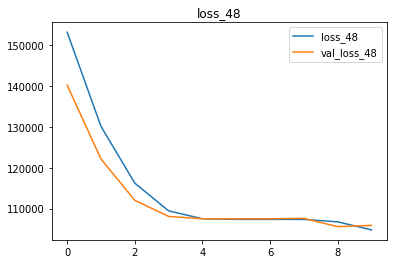

In [47]:
plt.plot(hist_48.history["loss"],label="loss_48")
plt.plot(hist_48.history["val_loss"],label="val_loss_48")
plt.title("loss_48")
plt.legend()

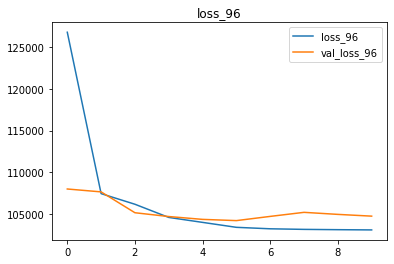

In [48]:
plt.plot(hist_96.history["loss"],label="loss_96")
plt.plot(hist_96.history["val_loss"],label="val_loss_96")
plt.title("loss_96")
plt.legend()

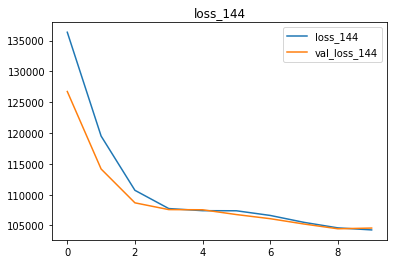

In [49]:
plt.plot(hist_144.history["loss"],label="loss_144")
plt.plot(hist_144.history["val_loss"],label="val_loss_144")
plt.title("loss_144")

plt.legend()

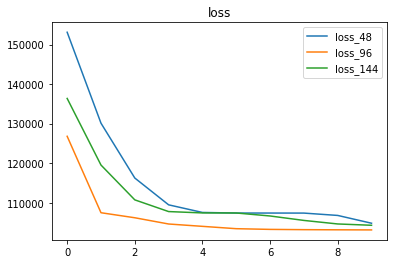

In [50]:
plt.plot(hist_48.history["loss"],label="loss_48")
plt.plot(hist_96.history["loss"],label="loss_96")
plt.plot(hist_144.history["loss"],label="loss_144")
plt.title("loss")
plt.legend()

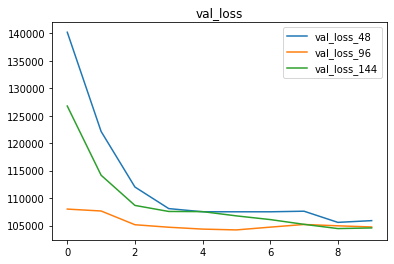

In [51]:
plt.plot(hist_48.history["val_loss"],label="val_loss_48")
plt.plot(hist_96.history["val_loss"],label="val_loss_96")
plt.plot(hist_144.history["val_loss"],label="val_loss_144")
plt.title("val_loss")
plt.legend()

In [58]:
test_sequences = createSequence(test,window_size=96)

test_GHI = test_GHI[:len(test_sequences)].reshape(-1,1)
print(test_sequences.shape)
test_GHI.shape

(17425, 96, 8)


(17425, 1)

In [59]:
evaluation = model_96.evaluate(test_sequences,test_GHI)

545/545 [==============================] - 6s 10ms/step - loss: 84666.3047
